In [1]:
import glob
import pandas as pd
#import random
#import paho.mqtt.client as mqtt
import string
import time
import matplotlib.pyplot as plt
import numpy as np
import statistics #Group B - find mean
from scipy.constants import c, m_p, e

In [2]:
files = glob.glob(r"C:\Users\ilw61967\Desktop\BLM_R5IM_Data\cycle" + '/*.csv')

In [3]:
selected_file = files[5]
input_data = pd.read_csv(selected_file)
array = input_data.drop(columns = input_data.columns[0]).to_numpy()
print(array)

[[-4.99939013e+00 -4.99939013e+00 -4.99939013e+00 ... -4.99939013e+00
  -4.99939013e+00 -4.99939013e+00]
 [-4.87999991e-03 -4.26999992e-03 -4.26999992e-03 ... -6.09999988e-03
  -3.65999993e-03 -4.26999992e-03]
 [-1.21999998e-03 -6.09999988e-04 -6.09999988e-04 ...  1.21999998e-03
   4.87999991e-03  4.26999992e-03]
 ...
 [ 1.82999996e-03  1.21999998e-03  4.26999992e-03 ... -1.21999998e-03
   2.43999995e-03  1.21999998e-03]
 [-3.04999994e-03 -1.82999996e-03 -1.21999998e-03 ...  1.21999998e-03
  -2.43999995e-03  6.09999988e-04]
 [ 3.53999995e-02  3.60100009e-02  3.66199985e-02 ...  2.31899992e-02
   2.25799996e-02  2.25799996e-02]]


Group 1A data filtering class

In [4]:
from copy import deepcopy

import numpy as np


class DataFilter:
  '''A object with configurable settings to filter input data.
  '''

  labels = ["r0blm1", "r0blm3", "r0blm4",
            "r1blm1", "r1blm2", "r1blm3", "r1blm4",
            "r2blm1", "r2blm2", "r2blm3", "r2blm4",
            "r3blm1", "r3blm2", "r3blm3", "r3blm4",
            "r4blm1", "r4blm2", "r4blm3", "r4blm4",
            "r5blm1", "r5blm2", "r5blm3", "r5blm4",
            "r6blm1", "r6blm2", "r6blm3", "r6blm4",
            "r7blm1", "r7blm2", "r7blm3", "r7blm4",
            "r8blm1", "r8blm2", "r8blm3", "r8blm4",
            "r9blm1", "r9blm2", "r9blm3", "r9blm4",
            "r5im"]
  
  
  def __init__(self, *, select = True, invert = False, scale = 1, offset = 0, auto_offset = 0):
    '''Creates a filterer object, with configurable settings to filter input data.
    '''

    self.data = []

    template = {
      "select": select,
      "invert": invert,
      "scale": scale,
      "offset": offset,
      "auto_offset": auto_offset,
    }

    self.settings = [deepcopy(template) for i in range(40)]

  def _index_(self, label) -> int:
    '''A minor inner method to convert the string name of a BLM to its corresponding index.'''

    if isinstance(label, int):
      return label
    elif isinstance(label, str):
      return DataFilter.labels.index(label)
    else:
      raise TypeError

  
  def invert(self, data: np.array) -> np.array:
    out = -data
    return out

  def scale(self, data: np.array, factor: int | float) -> np.array:
    out = data * factor
    return out
  
  def offset(self, data: np.array, *, offset: int | float = 0, points: int = None) -> np.array:
    '''Offsets data by either `offset`, or zeroes it using a given number of data points as reference for the zero-level.'''
    
    out = data

    if isinstance(points, int):
      if points > 0:
        auto_offset = np.mean(data[:points])
      elif points < 0:
        auto_offset = np.mean(data[points:])
      else:
        raise ValueError("Invalid value for number of reference points")
      out = data - auto_offset

    if offset != 0:
      out = data + offset
    
    return out

  
  def set(self, setting: str, state, labels: list[str | int] = None) -> None:
    '''Configures a particular filter `setting` for a number of BLMs.

    `setting`: the filter setting to configure.
    `state`: the value to set the setting to.
    `labels`: the BLMs to apply the setting to.
    '''

    # if none specified, set for all
    if labels is None:
      for each in self.settings:
        each[setting] = state
    
    else:
      # single specified
      if isinstance(labels, str) or isinstance(labels, int):
        self.settings[self._index_(labels)][setting] = state

      # multiple specified
      else:
        for each in labels:
          self.settings[self._index_(each)][setting] = state

  
  def reset(self) -> None:
    '''Resets filters to their default settings.'''

    self.settings = [{
      "select": True,
      "invert": False,
      "scale": 1,
      "offset": 0,
      "auto_offset": 0
    }] * 40

  
  def apply(self, data: np.array) -> np.array:
    '''Filters `data` according to the configured settings.'''
    
    self.data = data
  
    for i, each in enumerate(self.settings):
      # skip if not selected
      if not each["select"]:
        continue

      self.data[i] = data[i]

      if each["invert"]:
        self.data[i] = self.invert(self.data[i])

      if each["scale"] != 1:
        self.data[i] = self.scale(self.data[i], each["scale"])

      if each["offset"] != 0:
        self.data[i] = self.offset(self.data[i], offset = each["offset"])

      if each["auto_offset"] != 0:
        self.data[i] = self.offset(self.data[i], points = each["auto_offset"])

    return [each for i, each in enumerate(self.data) if self.settings[i]["select"]]


In [5]:
def offset_y_data(data, offset = None, n = None, SpecialPoint = None):
    '''Offsets data in y axis by designated value.
    '''

    out = data

    if offset != None:
        out = data + offset
    if SpecialPoint != None:
        out = data - SpecialPoint
        return out

    elif isinstance(n, int):
        if n > 0:
            offset = np.mean(data[:n])
        elif n < 0:
            offset = np.mean(data[n:])
        else:
            raise ValueError("Invalid value for n")
        out = data - offset
    
    return out


Sum of all BLMs minus R0BLM1 and R5IM

In [6]:
filterer.set("select", False, ["r0blm1","r5im"]) #removes r0blm1 and r5im from the array
filteredArray = filterer.apply(array)

NameError: name 'filterer' is not defined

In [ ]:
result = np.sum(filteredArray, 0) #returns list of 2200 values
print(result)

In [7]:
def sumBLMs(array): 
    filterer = DataFilter()
    filterer.set("select", False, ["r0blm1","r5im"]) #removes r0blm1 and r5im from the array
    filteredArray = filterer.apply(array)
    result = np.sum(filteredArray, 0)
    return result

print(sumBLMs(array))

[-0.10067 -0.07198 -0.061   ... -0.09763 -0.07689 -0.08726]


Sum of all BLMs minus R0BLM1 and R5IM and superperiods 1 and 2

In [8]:
filterer.set("select", False, ["r0blm1","r5im"]) #removes r0blm1 and r5im from the array
filteredArray = filterer.apply(array)

NameError: name 'filterer' is not defined

In [9]:
filterer.set("select", False, ["r1blm1","r1blm2","r1blm3","r1blm4","r2blm1","r2blm2","r2blm3","r2blm4"])
filteredArray = filterer.apply(array) #removes r1 and r2 from the array

NameError: name 'filterer' is not defined

In [10]:
result = np.sum(filteredArray, 0) #returns list of 2200 values
print(result)

NameError: name 'filteredArray' is not defined

In [11]:
def sumBLMs_exclude12(array):
    filterer = DataFilter()
    filterer.set("select", False, ["r0blm1","r5im"]) #removes r0blm1 and r5im from the array
    filterer.set("select", False, ["r1blm1","r1blm2","r1blm3","r1blm4","r2blm1","r2blm2","r2blm3","r2blm4"]) #removes r1 and r2 from the array
    filteredArray = filterer.apply(array)
    result = np.sum(filteredArray, 0)
    return result

print(sumBLMs_exclude12(array))

[-0.06895 -0.04087 -0.03233 ... -0.05919 -0.04578 -0.0531 ]


Filtering data to offset all BLMs and invert R5IM

In [12]:
filterer.reset()
x_data = np.linspace(-0.5,10.5,2200)
y_data = offset_y_data(array, SpecialPoint = np.min(array[3]))
plt.plot(x_data, y_data[3])

NameError: name 'filterer' is not defined

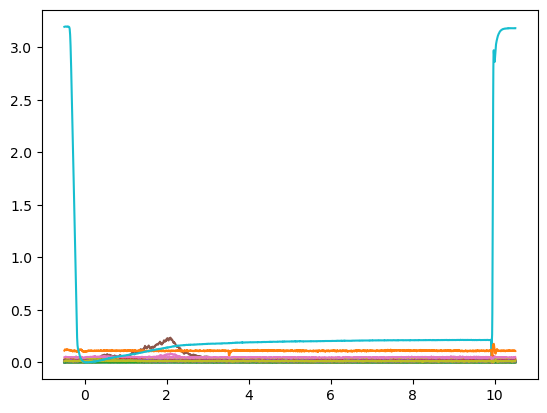

In [13]:
newArray = []
for i in array:
    offsetData = offset_y_data(i, SpecialPoint = np.min(i))
    newArray.append(offsetData)

x_data = np.linspace(-0.5,10.5,2200)
for i in newArray:
    plt.plot(x_data, i)

In [14]:
def cleanData(array): 
    filterer = DataFilter()
    filterer.set("invert","r5im")
    array = filterer.apply(array)
    
    for i in array:
        offsetData = offset_y_data(i, SpecialPoint = np.min(i))
        newArray.append(offsetData)

    newArray.append(array[39])
    
    return newArray    

In [15]:
cleanData(array)

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.00489, 0.0055 , 0.0055 , ..., 0.00367, 0.00611, 0.0055 ]),
 array([0.01526, 0.01587, 0.01587, ..., 0.0177 , 0.02136, 0.02075]),
 array([0.0055 , 0.0055 , 0.00733, ..., 0.00427, 0.00733, 0.00733]),
 array([0.00977, 0.01099, 0.0116 , ..., 0.01038, 0.01099, 0.01038]),
 array([0.00488, 0.00305, 0.00366, ..., 0.00061, 0.00183, 0.00305]),
 array([0.00183, 0.00122, 0.00305, ..., 0.00305, 0.00244, 0.00244]),
 array([0.00244, 0.00183, 0.00244, ..., 0.00061, 0.00244, 0.00183]),
 array([0.00367, 0.00489, 0.00367, ..., 0.00306, 0.00367, 0.00306]),
 array([0.01342, 0.01464, 0.01159, ..., 0.01159, 0.01281, 0.00976]),
 array([0.00305, 0.00305, 0.00427, ..., 0.00427, 0.00366, 0.00427]),
 array([0.0055 , 0.00611, 0.00489, ..., 0.00244, 0.00366, 0.00305]),
 array([0.0055 , 0.00611, 0.00489, ..., 0.00916, 0.00977, 0.00977]),
 array([0.02808, 0.0293 , 0.02381, ..., 0.03296, 0.03235, 0.03174]),
 array([0.00672, 0.0055 , 0.00733, ..., 0.00672, 0.00916, 0.0097

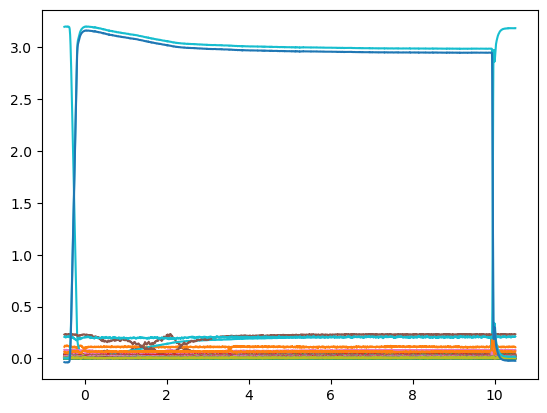

In [16]:
x_data = np.linspace(-0.5,10.5,2200)
for i in newArray:
    plt.plot(x_data, i)

In [17]:
np.shape(newArray)

(81, 2200)